# 1 - Import requirements

In [1]:
# ! pip install ta

In [1]:
import os
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler

from ta import add_all_ta_features
from ta.momentum import RSIIndicator, StochasticOscillator, WilliamsRIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.trend import MACD, ADXIndicator

from tqdm import tqdm

# 2 - Prepare data

In [2]:
# 1. Hàm load data
def load_data(file_path):
    df = pd.read_csv(file_path)
    # Xử lý datetime
    df['Datetime'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Datetime').drop(['Date'], axis=1)
    return df

train_df = load_data("data/bitcoin/dynamic_labeled_train.csv")
val_df = load_data("data/bitcoin/dynamic_labeled_dev.csv")
test_df = load_data("data/bitcoin/dynamic_labeled_test.csv")

# train_df = train_df.loc[train_df['Datetime'].dt.year.isin(range(2018, 2021))]

train_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Label', 'Datetime'], dtype='object')

In [3]:
train_df['Label'].value_counts()

Label
HOLD    602861
BUY     271245
SELL    177062
Name: count, dtype: int64

In [4]:
label_mapping = {
    'BUY': 0,
    'SELL': 1,
    'HOLD': 2
}

def map_label(x):
    return label_mapping[x] if x in label_mapping else x

train_df['Label'] = train_df['Label'].map(map_label)
val_df['Label'] = val_df['Label'].map(map_label)
test_df['Label'] = test_df['Label'].map(map_label)

In [5]:
# 2. Hàm thêm basic features
def add_basic_features(df):
    df['Price_Spread'] = df['High'] - df['Low']
    df['Price_Change'] = df['Close'] - df['Open']
    df['Body_Ratio'] = (df['Close'] - df['Open']) / (df['Price_Spread'] + 1e-8)
    df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
    
    df['Cumulative_Return_5D'] = np.exp(df['Log_Return'].rolling(5).sum()) - 1  # Lũy kế 5 ngày
    
    return df

for df in [train_df, val_df, test_df]:
    df = add_basic_features(df)
    
train_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Label', 'Datetime',
       'Price_Spread', 'Price_Change', 'Body_Ratio', 'Log_Return',
       'Cumulative_Return_5D'],
      dtype='object')

In [6]:
# 3. Hàm thêm technical indicators
def add_technical_indicators(df):
    # # Sử dụng thư viện 'ta'
    # df = add_all_ta_features(
    #     df, open="Open", high="High", low="Low", close="Close", volume="Volume"
    # )
    
    # Volume-Weighted Momentum
    df['VW_Momentum'] = (df['Volume'] * (df['Close'] - df['Close'].shift(1))).rolling(5).sum()

    # On-Balance Volume (OBV)
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).cumsum()
    
    # # Stochastic Oscillator
    # stoch = StochasticOscillator(high=df['High'], low=df['Low'], close=df['Close'], window=14)
    # df['Stoch_%K'] = stoch.stoch()
    # df['Stoch_%D'] = stoch.stoch_signal()

    # # Williams %R
    # williams = WilliamsRIndicator(high=df['High'], low=df['Low'], close=df['Close'], lbp=14)
    # df['Williams_%R'] = williams.williams_r()

    # df = df.copy()
    # # Average True Range (ATR)
    # atr = AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], window=14)
    # df['ATR'] = atr.average_true_range()
    
    indic_cols = {}
    # Thêm indicators custom
    rsi = RSIIndicator(close=df['Close'], window=14)
    indic_cols['RSI_14'] = rsi.rsi()
    
    macd = MACD(close=df['Close'])
    indic_cols['MACD'] = macd.macd()
    indic_cols['MACD_Signal'] = macd.macd_signal()
    
    bb = BollingerBands(close=df['Close'], window=20, window_dev=2)
    indic_cols['BB_Upper'] = bb.bollinger_hband()
    indic_cols['BB_Lower'] = bb.bollinger_lband()
    
    df = pd.concat([df, pd.DataFrame(indic_cols)], axis=1)
    df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']
    
    # # Kết hợp RSI và MACD
    # df['RSI_MACD_Interaction'] = df['RSI_14'] * df['MACD_Histogram']

    # # Tương quan Volume-Giá
    # df['Volume_Price_Correlation'] = df['Volume'].rolling(10).corr(df['Close'])
    
    # ADX để xác định thị trường có trend hay range
    adx = ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=14)
    df['ADX'] = adx.adx()
    df['Market_Trend'] = (df['ADX'] > 25).astype(int)  # >25: có xu hướng
    
    return df

train_df = add_technical_indicators(train_df)
val_df = add_technical_indicators(val_df)
test_df = add_technical_indicators(test_df)

train_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Label', 'Datetime',
       'Price_Spread', 'Price_Change', 'Body_Ratio', 'Log_Return',
       'Cumulative_Return_5D', 'VW_Momentum', 'OBV', 'RSI_14', 'MACD',
       'MACD_Signal', 'BB_Upper', 'BB_Lower', 'MACD_Histogram', 'ADX',
       'Market_Trend'],
      dtype='object')

In [7]:
# 4. Hàm thêm statistical features
def add_statistical_features(df, window=20):
    new_cols = {
        'Rolling_Mean': df['Close'].rolling(window).mean(),
        'Rolling_Std': df['Close'].rolling(window).std(),
        'Rolling_Max': df['High'].rolling(window).max(),
        'Rolling_Min': df['Low'].rolling(window).min()
    }
    df = pd.concat([df, pd.DataFrame(new_cols)], axis=1)
    
    # # Biến động "nén" trong ngắn hạn
    # df['Volatility_Clustering'] = df['Rolling_Std'] / df['Rolling_Std'].shift(5)
    
    # df['Rolling_Skew'] = df['Close'].rolling(window).skew()
    # df['Rolling_Kurtosis'] = df['Close'].rolling(window).kurt()
    # df['Rolling_Q80'] = df['Close'].rolling(window).quantile(0.8)
    # df['Rolling_Q20'] = df['Close'].rolling(window).quantile(0.2)
    # df['Quantile_Spread'] = df['Rolling_Q80'] - df['Rolling_Q20']  # Độ phân tán phân vị
    
    return df

train_df = add_statistical_features(train_df)
val_df = add_statistical_features(val_df)
test_df = add_statistical_features(test_df)

train_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Label', 'Datetime',
       'Price_Spread', 'Price_Change', 'Body_Ratio', 'Log_Return',
       'Cumulative_Return_5D', 'VW_Momentum', 'OBV', 'RSI_14', 'MACD',
       'MACD_Signal', 'BB_Upper', 'BB_Lower', 'MACD_Histogram', 'ADX',
       'Market_Trend', 'Rolling_Mean', 'Rolling_Std', 'Rolling_Max',
       'Rolling_Min'],
      dtype='object')

In [8]:
# 5. Hàm thêm time-based features
def add_time_features(df, threshold=10):
    # new_cols = {
    #     'Hour': df['Datetime'].dt.hour,
    #     'DayOfWeek': df['Datetime'].dt.dayofweek  # 0=Monday
    # }
    
    # # Cyclical encoding cho giờ và ngày
    # new_cols['Hour_sin'] = np.sin(2 * np.pi * new_cols['Hour']/24)
    # new_cols['Hour_cos'] = np.cos(2 * np.pi * new_cols['Hour']/24)
    # new_cols['Day_sin'] = np.sin(2 * np.pi * new_cols['DayOfWeek']/7)
    # new_cols['Day_cos'] = np.cos(2 * np.pi * new_cols['DayOfWeek']/7)
    
    # df = pd.concat([df, pd.DataFrame(new_cols)], axis=1)
    
    df['Timedelta'] = df['Datetime'].diff().dt.total_seconds().div(60).fillna(0)
    
    df['Is_big_delta'] = (df['Timedelta'] > threshold).astype(int)
    
    return df

train_df = add_time_features(train_df)
val_df = add_time_features(val_df)
test_df = add_time_features(test_df)

train_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Label', 'Datetime',
       'Price_Spread', 'Price_Change', 'Body_Ratio', 'Log_Return',
       'Cumulative_Return_5D', 'VW_Momentum', 'OBV', 'RSI_14', 'MACD',
       'MACD_Signal', 'BB_Upper', 'BB_Lower', 'MACD_Histogram', 'ADX',
       'Market_Trend', 'Rolling_Mean', 'Rolling_Std', 'Rolling_Max',
       'Rolling_Min', 'Timedelta', 'Is_big_delta'],
      dtype='object')

In [9]:
def drop_na_cols(df, threshold=0.01):
    cnt = 0
    for col in df.columns:
        na = df[[col]].isna().sum()
        if na.values > len(df) * threshold:
            df.drop(col, axis=1, inplace=True)
            cnt += 1
    print(f'Deleted {cnt} cols')
    return df

# 6. Hàm xử lý missing values
def handle_missing_data(df, threshold=0.01):
    df = drop_na_cols(df, threshold)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Xóa các hàng có NaN sinh ra bởi indicators
    # print(df.isna().sum())
    df = df.dropna()
    # # Forward fill cho các features nhất định
    # df.loc[:, ['Volume', 'Open']] = df[['Volume', 'Open']].ffill()
    return df

# for df in [train_df, val_df, test_df]:
#     df = handle_missing_data(df)

# train_df
train_df = handle_missing_data(train_df)
val_df = handle_missing_data(val_df)
test_df = handle_missing_data(test_df)
train_df.columns

Deleted 0 cols
Deleted 0 cols
Deleted 0 cols


Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Label', 'Datetime',
       'Price_Spread', 'Price_Change', 'Body_Ratio', 'Log_Return',
       'Cumulative_Return_5D', 'VW_Momentum', 'OBV', 'RSI_14', 'MACD',
       'MACD_Signal', 'BB_Upper', 'BB_Lower', 'MACD_Histogram', 'ADX',
       'Market_Trend', 'Rolling_Mean', 'Rolling_Std', 'Rolling_Max',
       'Rolling_Min', 'Timedelta', 'Is_big_delta'],
      dtype='object')

In [10]:
# 7. Hàm chuẩn hóa dữ liệu (Áp dụng riêng cho từng tập)
def scale_features(train_df, val_df, test_df, excepts=['Label', 'Datetime'], scaler_path='data/scaler.pkl'):
    # Chọn các cột cần chuẩn hóa (bỏ các cột không phải số)
    feature_columns = [col for col in train_df.columns if col not in excepts]
    
    # Chuẩn hóa theo train
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_df[feature_columns])
    val_scaled = scaler.transform(val_df[feature_columns])
    test_scaled = scaler.transform(test_df[feature_columns])
    
    # Tạo DataFrame mới đã scaled
    scaled_train_df = pd.DataFrame(train_scaled, columns=feature_columns, index=train_df.index)
    scaled_val_df = pd.DataFrame(val_scaled, columns=feature_columns, index=val_df.index)
    scaled_test_df = pd.DataFrame(test_scaled, columns=feature_columns, index=test_df.index)
    
    # Thêm lại các cột không phải feature
    for scaled_df, df in zip([scaled_train_df, scaled_val_df, scaled_test_df], [train_df, val_df, test_df]):
        for col in excepts:
            scaled_df[col] = df[col].values
    
    pickle.dump(scaler, open(scaler_path, 'wb'))
    
    return scaled_train_df, scaled_val_df, scaled_test_df

train_df, val_df, test_df = scale_features(train_df, val_df, test_df, excepts=['Label', 'Datetime'], scaler_path='data/xauusd/kaggle/classfication_scaler.pkl')
train_df

,Open,High,Low,Close,Volume,Price_Spread,Price_Change,Body_Ratio,Log_Return,Cumulative_Return_5D,...,ADX,Market_Trend,Rolling_Mean,Rolling_Std,Rolling_Max,Rolling_Min,Timedelta,Is_big_delta,Label,Datetime
33,2.477980,2.479344,2.461383,2.459857,0.121010,4.671832,-4.289649,-0.982796,-2.683378,-1.692208,...,1.886763,1.168151,2.466026,1.688532,2.473845,2.471806,-0.000975,0.0,2,2018-01-01 00:34:00
34,2.459643,2.479253,2.465173,2.484619,-0.361626,3.938236,5.822848,1.513074,3.621533,0.768408,...,1.729570,1.168151,2.466633,1.773725,2.473845,2.471806,-0.000975,0.0,1,2018-01-01 00:35:00
35,2.484170,2.479028,2.489727,2.484382,-0.356424,-0.746012,0.012102,-0.769015,-0.034095,0.777048,...,1.583606,1.168151,2.467838,1.841968,2.473845,2.471806,-0.000975,0.0,1,2018-01-01 00:36:00
36,2.478217,2.479454,2.466510,2.474308,0.793332,3.723616,-0.954657,-0.274083,-1.470721,-0.548135,...,1.545997,1.168151,2.469037,1.759489,2.473845,2.471806,-0.000975,0.0,1,2018-01-01 00:37:00
37,2.461361,2.472629,2.466894,2.476777,-0.056599,2.357377,3.579746,1.400867,0.361332,-0.099802,...,1.511074,1.168151,2.470536,1.618920,2.473845,2.471806,-0.000975,0.0,1,2018-01-01 00:38:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051163,-0.107314,-0.109100,-0.108113,-0.109936,-0.371162,-0.242739,-0.613557,-1.529792,-0.126586,-0.571810,...,-0.898284,-0.856054,-0.106460,-0.487698,-0.112997,-0.100631,-0.000975,0.0,0,2019-12-31 23:25:00
1051164,-0.109088,-0.108958,-0.107726,-0.107120,-0.315620,-0.289103,0.463503,1.191687,0.788020,0.205977,...,-0.984978,-0.856054,-0.106428,-0.491030,-0.112997,-0.100631,-0.000975,0.0,2,2019-12-31 23:26:00
1051165,-0.109084,-0.110868,-0.107421,-0.109245,-0.372210,-0.708622,-0.036097,-1.529792,-0.593678,-0.297765,...,-1.065479,-0.856054,-0.106635,-0.477158,-0.112997,-0.100631,-0.000975,0.0,2,2019-12-31 23:27:00
1051166,-0.107172,-0.108891,-0.105293,-0.107052,-0.357777,-0.736290,0.029713,1.513317,0.613422,0.163565,...,-1.085443,-0.856054,-0.106732,-0.482639,-0.112997,-0.100631,-0.000975,0.0,2,2019-12-31 23:28:00


<Axes: >

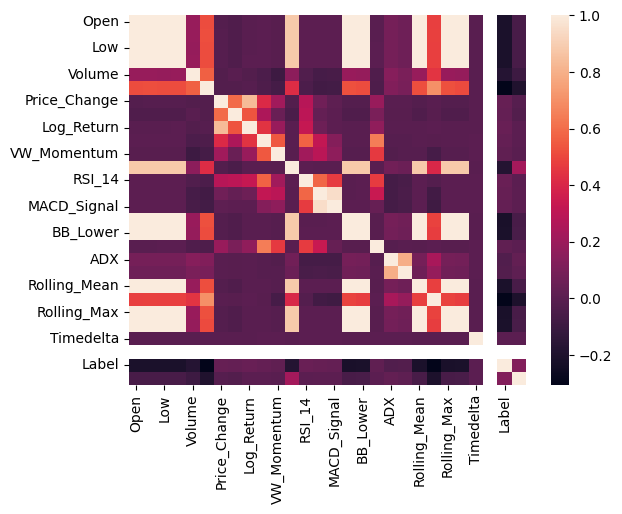

In [11]:
import seaborn as sns
sns.heatmap(train_df.corr())

In [12]:
def correlation(train, val, test, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = train.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in train.columns:
                    del train[colname] # deleting the column from the dataset
    val = val[train.columns]
    test = test[train.columns]

    return train, val, test
    
train_df, val_df, test_df = correlation(train_df, val_df, test_df, 0.8)

In [13]:
train_df

,Open,Volume,Price_Spread,Price_Change,Body_Ratio,Cumulative_Return_5D,VW_Momentum,RSI_14,MACD,MACD_Histogram,ADX,Market_Trend,Rolling_Std,Timedelta,Is_big_delta,Label,Datetime
33,2.477980,0.121010,4.671832,-4.289649,-0.982796,-1.692208,0.137860,-1.031632,-1.214523,1.494796,1.886763,1.168151,1.688532,-0.000975,0.0,2,2018-01-01 00:34:00
34,2.459643,-0.361626,3.938236,5.822848,1.513074,0.768408,0.160449,0.216298,-0.917263,1.984137,1.729570,1.168151,1.773725,-0.000975,0.0,1,2018-01-01 00:35:00
35,2.484170,-0.356424,-0.746012,0.012102,-0.769015,0.777048,0.161117,0.205100,-0.678060,2.221648,1.583606,1.168151,1.841968,-0.000975,0.0,1,2018-01-01 00:36:00
36,2.478217,0.793332,3.723616,-0.954657,-0.274083,-0.548135,-0.344984,-0.261422,-0.660956,1.822673,1.545997,1.168151,1.759489,-0.000975,0.0,1,2018-01-01 00:37:00
37,2.461361,-0.056599,2.357377,3.579746,1.400867,-0.099802,-0.328269,-0.140613,-0.596333,1.629507,1.511074,1.168151,1.618920,-0.000975,0.0,1,2018-01-01 00:38:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051163,-0.107314,-0.371162,-0.242739,-0.613557,-1.529792,-0.571810,0.007872,-1.095197,-0.192062,-0.338644,-0.898284,-0.856054,-0.487698,-0.000975,0.0,0,2019-12-31 23:25:00
1051164,-0.109088,-0.315620,-0.289103,0.463503,1.191687,0.205977,0.010684,-0.186880,-0.172653,-0.219449,-0.984978,-0.856054,-0.491030,-0.000975,0.0,2,2019-12-31 23:26:00
1051165,-0.109084,-0.372210,-0.708622,-0.036097,-1.529792,-0.297765,0.010109,-0.712840,-0.193006,-0.229537,-1.065479,-0.856054,-0.477158,-0.000975,0.0,2,2019-12-31 23:27:00
1051166,-0.107172,-0.357777,-0.736290,0.029713,1.513317,0.163565,0.010802,-0.098864,-0.167952,-0.117191,-1.085443,-0.856054,-0.482639,-0.000975,0.0,2,2019-12-31 23:28:00


In [14]:
def create_sequences_sequential(X, y, sequence_length, save_path, idx_file, target='Label',stride=1):
    """
    Tạo sequences từng sample một, dùng memmap để lưu đúng shape
    """
    try:
        n_samples = int(np.ceil((len(X) - sequence_length) / stride))
        n_features = X.shape[1]
        if n_samples <= 0:
            raise ValueError("Input array too short for given sequence_length")
        
        # Chuẩn bị file memmap
        os.makedirs(save_path, exist_ok=True)
        sequences_file = f'{save_path}/sequences.dat'
        labels_file = f'{save_path}/labels.dat'
        shape_file = f'{save_path}/shape.txt'
        
        # Đọc index khởi đầu
        start_idx = 0
        if os.path.exists(idx_file):
            with open(idx_file, 'r') as f:
                start_idx = int(f.read().strip() or 0)
        else:
            if os.path.exists(sequences_file):
                os.remove(sequences_file)
            if os.path.exists(labels_file):
                os.remove(labels_file)
            if os.path.exists(shape_file):
                os.remove(shape_file)
        
        # Tạo memmap với shape đầy đủ
        sequences = np.memmap(sequences_file, dtype=np.float32, mode='w+', 
                            shape=(n_samples, sequence_length, n_features))
        labels = np.memmap(labels_file, dtype=np.int64, mode='w+', shape=(n_samples,))
        
        # Ghi dữ liệu từ start_idx
        for i in tqdm(range(start_idx, (len(X) - sequence_length), stride)):
            sequences[i // stride] = X[i:i+sequence_length]
            labels[i // stride] = y[target].values[i + sequence_length]
            
            # Ghi index hiện tại
            with open(idx_file, 'w') as f:
                f.write(str(i + 1))
        
        # Lưu shape vào file
        with open(shape_file, 'w') as f:
            f.write(f"{n_samples}\n{sequence_length}\n{n_features}")
        
        # Flush để đảm bảo dữ liệu được ghi
        sequences.flush()
        labels.flush()
        print(f"Sequences saved to {save_path}, shape: {sequences.shape}")
        return n_samples, n_features
    except Exception as e:
        print(e)
        start_idx = 0
        if os.path.exists(idx_file):
            with open(idx_file, 'r') as f:
                start_idx = int(f.read().strip() or 0)
        return start_idx, n_features

In [15]:
# [batch_size, seq_len, n_features]
# [[seq_len, n_features]]

In [16]:
train_df.columns

Index(['Open', 'Volume', 'Price_Spread', 'Price_Change', 'Body_Ratio',
       'Cumulative_Return_5D', 'VW_Momentum', 'RSI_14', 'MACD',
       'MACD_Histogram', 'ADX', 'Market_Trend', 'Rolling_Std', 'Timedelta',
       'Is_big_delta', 'Label', 'Datetime'],
      dtype='object')

In [ ]:
save_path = 'data/bitcoin/classification'
sequence_length = 128

feature_columns = [col for col in train_df.columns if col not in ['Datetime', 'Label']]
X_train = train_df[feature_columns].values
X_val = val_df[feature_columns].values
X_test = test_df[feature_columns].values

train_path = f'{save_path}/train'
val_path = f'{save_path}/val'
test_path = f'{save_path}/test' 

train_idx_file = f'{save_path}/train_idx.txt'
val_idx_file = f'{save_path}/val_idx.txt'
test_idx_file = f'{save_path}/test_idx.txt'

# target='Label'
# stride = 5
# print("Processing train data...")
# n_train_samples, n_features = create_sequences_sequential(X_train, train_df, sequence_length, train_path, train_idx_file, target=target, stride=stride)
# print("Processing validation data...")
# n_val_samples, _ = create_sequences_sequential(X_val, val_df, sequence_length, val_path, val_idx_file, target=target, stride=stride)
# print("Processing test data...")
# n_test_samples, _ = create_sequences_sequential(X_test, test_df, sequence_length, test_path, test_idx_file, target=target, stride=stride)

Processing train data...


100%|██████████| 210202/210202 [01:11<00:00, 2927.74it/s]


Sequences saved to data/bitcoin/classification/train, shape: (210202, 128, 15)
Processing validation data...


100%|██████████| 97507/97507 [00:35<00:00, 2738.66it/s]


Sequences saved to data/bitcoin/classification/val, shape: (97507, 128, 15)
Processing test data...


100%|██████████| 105082/105082 [00:35<00:00, 2968.66it/s]


Sequences saved to data/bitcoin/classification/test, shape: (105082, 128, 15)


# Reg

In [19]:
# print('Load data')
# train_df = load_data("data/regression_train.csv")
# val_df = load_data("data/regression_dev.csv")
# test_df = load_data("data/regression_test.csv")

# train_df = train_df.loc[train_df['Datetime'].dt.year.isin(range(2018, 2021))]

# for df in [train_df, val_df, test_df]:
#     df = add_basic_features(df)

# print('add_technical_indicators')
# train_df = add_technical_indicators(train_df)
# val_df = add_technical_indicators(val_df)
# test_df = add_technical_indicators(test_df)

# print('add_statistical_features')
# train_df = add_statistical_features(train_df)
# val_df = add_statistical_features(val_df)
# test_df = add_statistical_features(test_df)

# print('add_time_features')
# train_df = add_time_features(train_df)
# val_df = add_time_features(val_df)
# test_df = add_time_features(test_df)

# print('handle_missing_data')
# train_df = handle_missing_data(train_df)
# val_df = handle_missing_data(val_df)
# test_df = handle_missing_data(test_df)

# print('scale_features')
# train_df, val_df, test_df = scale_features(train_df, val_df, test_df, excepts=['Price_t_plus_30', 'Datetime'], scaler_path='data/regression_scaler_x.pkl')

# print('scale_outputs')
# scaler = StandardScaler()
# train_df['Price_t_plus_30'] = scaler.fit_transform(train_df[['Price_t_plus_30']])
# val_df['Price_t_plus_30'] = scaler.transform(val_df[['Price_t_plus_30']])
# test_df['Price_t_plus_30'] = scaler.transform(test_df[['Price_t_plus_30']])

# pickle.dump(scaler, open('data/regression_scaler_y.pkl', 'wb'))

In [20]:
# train_df

In [21]:
# save_path = 'data/regression'
# sequence_length = 128

# feature_columns = [col for col in train_df.columns if col not in ['Datetime', 'Price_t_plus_30', 'Open', 'High', 'Low', 'Close', 'Volume']]
# X_train = train_df[feature_columns].values
# X_val = val_df[feature_columns].values
# X_test = test_df[feature_columns].values

# train_path = f'{save_path}/train'
# val_path = f'{save_path}/val'
# test_path = f'{save_path}/test' 

# train_idx_file = f'{save_path}/train_idx.txt'
# val_idx_file = f'{save_path}/val_idx.txt'
# test_idx_file = f'{save_path}/test_idx.txt'

# target='Price_t_plus_30'
# print("Processing train data...")
# n_train_samples, n_features = create_sequences_sequential(X_train, train_df, sequence_length, train_path, train_idx_file, target=target, stride=10)
# print("Processing validation data...")
# n_val_samples, _ = create_sequences_sequential(X_val, val_df, sequence_length, val_path, val_idx_file, target=target, stride=10)
# print("Processing test data...")
# n_test_samples, _ = create_sequences_sequential(X_test, test_df, sequence_length, test_path, test_idx_file, target=target, stride=10)